# HRNet神经网络在遥感影像地块分割中的应用

## 模型的选择
该任务的数据集是遥感影像，但对比MMSegmentation库中的各类预训练模型以及数据集中大多数模型的性能评估都是基于城市场景（Cityscapes）或者日常生活场景（ADE20K、Pascal Context）的数据集进行的

所以最终我选用LoveDA遥感数据集作为数据集的baseline，该数据集是武汉大学测绘遥感信息工程国家重点实验室RSIDEA团队在地表覆盖分类方面的工作[4]。根据同为遥感影像分割任务的结果去选择适合的模型，可能提升模型训练与推理时的准确性与鲁棒性。

![在LoveDA测试集上获得的语义分割结果.png](./imgs/在LoveDA测试集上获得的语义分割结果.png)

计算机视觉领域有很多任务是位置敏感的，比如目标检测、语义分割、实例分割等等。

为了这些任务位置信息更加精准，很容易想到的做法就是维持高分辨率的feature map。

通过下采样得到强语义信息，然后再上采样恢复高分辨率恢复位置信息。

这种做法，会导致大量的有效信息在不断的上下采样过程中丢失。而HRNet通过并行多个分辨率的分支，加上不断进行不同分支之间的信息交互，同时达到强语义信息和精准位置信息的目的。

U-Net、SegNet、DeconvNet、Hourglass本质上都是这种结构。普通网络都是这种结构，不同分辨率之间是串联的。

![从低分辨率恢复高分辨率结构.png](./imgs/从低分辨率恢复高分辨率结构.png)


HRNet将不同分辨率的feature map进行并联，在并联的基础上，添加不同分辨率feature map之间的交互(fusion)

![HRNet结构.png](./imgs/HRNet结构.png)

同分辨率的层直接复制。需要升分辨率的使用bilinear upsample + 1x1卷积将channel数统一。需要降分辨率的使用strided 3x3 卷积。三个feature map融合的方式是相加。

![fushion.png](./imgs/fushion.png)

(a)图展示的是HRNetV1的特征选择，只使用分辨率最高的特征图。(b)图展示的是HRNetV2的特征选择，将所有分辨率的特征图(小的特征图进行upsample)进行concate，主要用于语义分割和面部关键点检测。(c)图展示的是HRNetV2p的特征选择，在HRNetV2的基础上，使用了一个特征金字塔，主要用于目标检测网络。

![特征选择.png](./imgs/特征选择.png)

HRNet创新点在于：将高低分辨率之间的链接由串联改为并联；在整个网络结构中都保持了高分辨率的表征(最上边那个通路)；在高低分辨率中引入了交互来提高模型性能。

In [ ]:
class HRNet(BaseModule):
    """HRNet backbone.

    `High-Resolution Representations for Labeling Pixels and Regions
    arXiv: <https://arxiv.org/abs/1904.04514>`_.

    Args:
        extra (dict): Detailed configuration for each stage of HRNet.
            There must be 4 stages, the configuration for each stage must have
            5 keys:

                - num_modules (int): The number of HRModule in this stage.
                - num_branches (int): The number of branches in the HRModule.
                - block (str): The type of convolution block.
                - num_blocks (tuple): The number of blocks in each branch.
                    The length must be equal to num_branches.
                - num_channels (tuple): The number of channels in each branch.
                    The length must be equal to num_branches.
        in_channels (int): Number of input image channels. Normally 3.
        conv_cfg (dict): Dictionary to construct and config conv layer.
            Default: None.
        norm_cfg (dict): Dictionary to construct and config norm layer.
            Use `BN` by default.
        norm_eval (bool): Whether to set norm layers to eval mode, namely,
            freeze running stats (mean and var). Note: Effect on Batch Norm
            and its variants only. Default: False.
        with_cp (bool): Use checkpoint or not. Using checkpoint will save some
            memory while slowing down the training speed. Default: False.
        frozen_stages (int): Stages to be frozen (stop grad and set eval mode).
            -1 means not freezing any parameters. Default: -1.
        zero_init_residual (bool): Whether to use zero init for last norm layer
            in resblocks to let them behave as identity. Default: False.
        multiscale_output (bool): Whether to output multi-level features
            produced by multiple branches. If False, only the first level
            feature will be output. Default: True.
        pretrained (str, optional): Model pretrained path. Default: None.
        init_cfg (dict or list[dict], optional): Initialization config dict.
            Default: None.

    Example:
        >>> from mmseg.models import HRNet
        >>> import torch
        >>> extra = dict(
        >>>     stage1=dict(
        >>>         num_modules=1,
        >>>         num_branches=1,
        >>>         block='BOTTLENECK',
        >>>         num_blocks=(4, ),
        >>>         num_channels=(64, )),
        >>>     stage2=dict(
        >>>         num_modules=1,
        >>>         num_branches=2,
        >>>         block='BASIC',
        >>>         num_blocks=(4, 4),
        >>>         num_channels=(32, 64)),
        >>>     stage3=dict(
        >>>         num_modules=4,
        >>>         num_branches=3,
        >>>         block='BASIC',
        >>>         num_blocks=(4, 4, 4),
        >>>         num_channels=(32, 64, 128)),
        >>>     stage4=dict(
        >>>         num_modules=3,
        >>>         num_branches=4,
        >>>         block='BASIC',
        >>>         num_blocks=(4, 4, 4, 4),
        >>>         num_channels=(32, 64, 128, 256)))
        >>> self = HRNet(extra, in_channels=1)
        >>> self.eval()
        >>> inputs = torch.rand(1, 1, 32, 32)
        >>> level_outputs = self.forward(inputs)
        >>> for level_out in level_outputs:
        ...     print(tuple(level_out.shape))
        (1, 32, 8, 8)
        (1, 64, 4, 4)
        (1, 128, 2, 2)
        (1, 256, 1, 1)
    """

    blocks_dict = {'BASIC': BasicBlock, 'BOTTLENECK': Bottleneck}

    def __init__(self,
                 extra,
                 in_channels=3,
                 conv_cfg=None,
                 norm_cfg=dict(type='BN', requires_grad=True),
                 norm_eval=False,
                 with_cp=False,
                 frozen_stages=-1,
                 zero_init_residual=False,
                 multiscale_output=True,
                 pretrained=None,
                 init_cfg=None):
        super(HRNet, self).__init__(init_cfg)

        self.pretrained = pretrained
        self.zero_init_residual = zero_init_residual
        assert not (init_cfg and pretrained), \
            'init_cfg and pretrained cannot be setting at the same time'
        if isinstance(pretrained, str):
            warnings.warn('DeprecationWarning: pretrained is deprecated, '
                          'please use "init_cfg" instead')
            self.init_cfg = dict(type='Pretrained', checkpoint=pretrained)
        elif pretrained is None:
            if init_cfg is None:
                self.init_cfg = [
                    dict(type='Kaiming', layer='Conv2d'),
                    dict(
                        type='Constant',
                        val=1,
                        layer=['_BatchNorm', 'GroupNorm'])
                ]
        else:
            raise TypeError('pretrained must be a str or None')

        # Assert configurations of 4 stages are in extra
        assert 'stage1' in extra and 'stage2' in extra \
               and 'stage3' in extra and 'stage4' in extra
        # Assert whether the length of `num_blocks` and `num_channels` are
        # equal to `num_branches`
        for i in range(4):
            cfg = extra[f'stage{i + 1}']
            assert len(cfg['num_blocks']) == cfg['num_branches'] and \
                   len(cfg['num_channels']) == cfg['num_branches']

        self.extra = extra
        self.conv_cfg = conv_cfg
        self.norm_cfg = norm_cfg
        self.norm_eval = norm_eval
        self.with_cp = with_cp
        self.frozen_stages = frozen_stages

        # stem net
        self.norm1_name, norm1 = build_norm_layer(self.norm_cfg, 64, postfix=1)
        self.norm2_name, norm2 = build_norm_layer(self.norm_cfg, 64, postfix=2)

        self.conv1 = build_conv_layer(
            self.conv_cfg,
            in_channels,
            64,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False)

        self.add_module(self.norm1_name, norm1)
        self.conv2 = build_conv_layer(
            self.conv_cfg,
            64,
            64,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False)

        self.add_module(self.norm2_name, norm2)
        self.relu = nn.ReLU(inplace=True)

        # stage 1
        self.stage1_cfg = self.extra['stage1']
        num_channels = self.stage1_cfg['num_channels'][0]
        block_type = self.stage1_cfg['block']
        num_blocks = self.stage1_cfg['num_blocks'][0]

        block = self.blocks_dict[block_type]
        stage1_out_channels = num_channels * block.expansion
        self.layer1 = self._make_layer(block, 64, num_channels, num_blocks)

        # stage 2
        self.stage2_cfg = self.extra['stage2']
        num_channels = self.stage2_cfg['num_channels']
        block_type = self.stage2_cfg['block']

        block = self.blocks_dict[block_type]
        num_channels = [channel * block.expansion for channel in num_channels]
        self.transition1 = self._make_transition_layer([stage1_out_channels],
                                                       num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        # stage 3
        self.stage3_cfg = self.extra['stage3']
        num_channels = self.stage3_cfg['num_channels']
        block_type = self.stage3_cfg['block']

        block = self.blocks_dict[block_type]
        num_channels = [channel * block.expansion for channel in num_channels]
        self.transition2 = self._make_transition_layer(pre_stage_channels,
                                                       num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)

        # stage 4
        self.stage4_cfg = self.extra['stage4']
        num_channels = self.stage4_cfg['num_channels']
        block_type = self.stage4_cfg['block']

        block = self.blocks_dict[block_type]
        num_channels = [channel * block.expansion for channel in num_channels]
        self.transition3 = self._make_transition_layer(pre_stage_channels,
                                                       num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multiscale_output=multiscale_output)

        self._freeze_stages()

    @property
    def norm1(self):
        """nn.Module: the normalization layer named "norm1" """
        return getattr(self, self.norm1_name)

    @property
    def norm2(self):
        """nn.Module: the normalization layer named "norm2" """
        return getattr(self, self.norm2_name)

    def _make_transition_layer(self, num_channels_pre_layer,
                               num_channels_cur_layer):
        """Make transition layer."""
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(
                        nn.Sequential(
                            build_conv_layer(
                                self.conv_cfg,
                                num_channels_pre_layer[i],
                                num_channels_cur_layer[i],
                                kernel_size=3,
                                stride=1,
                                padding=1,
                                bias=False),
                            build_norm_layer(self.norm_cfg,
                                             num_channels_cur_layer[i])[1],
                            nn.ReLU(inplace=True)))
                else:
                    transition_layers.append(None)
            else:
                conv_downsamples = []
                for j in range(i + 1 - num_branches_pre):
                    in_channels = num_channels_pre_layer[-1]
                    out_channels = num_channels_cur_layer[i] \
                        if j == i - num_branches_pre else in_channels
                    conv_downsamples.append(
                        nn.Sequential(
                            build_conv_layer(
                                self.conv_cfg,
                                in_channels,
                                out_channels,
                                kernel_size=3,
                                stride=2,
                                padding=1,
                                bias=False),
                            build_norm_layer(self.norm_cfg, out_channels)[1],
                            nn.ReLU(inplace=True)))
                transition_layers.append(nn.Sequential(*conv_downsamples))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        """Make each layer."""
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                build_conv_layer(
                    self.conv_cfg,
                    inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False),
                build_norm_layer(self.norm_cfg, planes * block.expansion)[1])

        layers = []
        block_init_cfg = None
        if self.pretrained is None and not hasattr(
                self, 'init_cfg') and self.zero_init_residual:
            if block is BasicBlock:
                block_init_cfg = dict(
                    type='Constant', val=0, override=dict(name='norm2'))
            elif block is Bottleneck:
                block_init_cfg = dict(
                    type='Constant', val=0, override=dict(name='norm3'))

        layers.append(
            block(
                inplanes,
                planes,
                stride,
                downsample=downsample,
                with_cp=self.with_cp,
                norm_cfg=self.norm_cfg,
                conv_cfg=self.conv_cfg,
                init_cfg=block_init_cfg))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(
                block(
                    inplanes,
                    planes,
                    with_cp=self.with_cp,
                    norm_cfg=self.norm_cfg,
                    conv_cfg=self.conv_cfg,
                    init_cfg=block_init_cfg))

        return Sequential(*layers)

    def _make_stage(self, layer_config, in_channels, multiscale_output=True):
        """Make each stage."""
        num_modules = layer_config['num_modules']
        num_branches = layer_config['num_branches']
        num_blocks = layer_config['num_blocks']
        num_channels = layer_config['num_channels']
        block = self.blocks_dict[layer_config['block']]

        hr_modules = []
        block_init_cfg = None
        if self.pretrained is None and not hasattr(
                self, 'init_cfg') and self.zero_init_residual:
            if block is BasicBlock:
                block_init_cfg = dict(
                    type='Constant', val=0, override=dict(name='norm2'))
            elif block is Bottleneck:
                block_init_cfg = dict(
                    type='Constant', val=0, override=dict(name='norm3'))

        for i in range(num_modules):
            # multi_scale_output is only used for the last module
            if not multiscale_output and i == num_modules - 1:
                reset_multiscale_output = False
            else:
                reset_multiscale_output = True

            hr_modules.append(
                HRModule(
                    num_branches,
                    block,
                    num_blocks,
                    in_channels,
                    num_channels,
                    reset_multiscale_output,
                    with_cp=self.with_cp,
                    norm_cfg=self.norm_cfg,
                    conv_cfg=self.conv_cfg,
                    block_init_cfg=block_init_cfg))

        return Sequential(*hr_modules), in_channels

    def _freeze_stages(self):
        """Freeze stages param and norm stats."""
        if self.frozen_stages >= 0:

            self.norm1.eval()
            self.norm2.eval()
            for m in [self.conv1, self.norm1, self.conv2, self.norm2]:
                for param in m.parameters():
                    param.requires_grad = False

        for i in range(1, self.frozen_stages + 1):
            if i == 1:
                m = getattr(self, f'layer{i}')
                t = getattr(self, f'transition{i}')
            elif i == 4:
                m = getattr(self, f'stage{i}')
            else:
                m = getattr(self, f'stage{i}')
                t = getattr(self, f'transition{i}')
            m.eval()
            for param in m.parameters():
                param.requires_grad = False
            t.eval()
            for param in t.parameters():
                param.requires_grad = False

    def forward(self, x):
        """Forward function."""

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.layer1(x)

        x_list = []
        for i in range(self.stage2_cfg['num_branches']):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)

        x_list = []
        for i in range(self.stage3_cfg['num_branches']):
            if self.transition2[i] is not None:
                x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)

        x_list = []
        for i in range(self.stage4_cfg['num_branches']):
            if self.transition3[i] is not None:
                x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage4(x_list)

        return y_list

    def train(self, mode=True):
        """Convert the model into training mode will keeping the normalization
        layer freezed."""
        super(HRNet, self).train(mode)
        self._freeze_stages()
        if mode and self.norm_eval:
            for m in self.modules():
                # trick: eval have effect on BatchNorm only
                if isinstance(m, _BatchNorm):
                    m.eval()

## 查看文件夹目录结构

In [ ]:
import seedir as sd
sd.seedir('remote_sensing_seg', style='emoji', depthlimit=1)

📁 remote_sensing_seg/
├─📁 img_testA/
├─📁 img_train/
└─📁 lab_train/


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 设置原始数据集路径
data_dir = 'remote_sensing_seg/'

# 设置新的数据集路径
new_data_dir = 'remote_sensing_seg/'

# 创建新的文件夹结构
os.makedirs(os.path.join(new_data_dir, 'img_dir', 'train'))
os.makedirs(os.path.join(new_data_dir, 'img_dir', 'val'))
os.makedirs(os.path.join(new_data_dir, 'ann_dir', 'train'))
os.makedirs(os.path.join(new_data_dir, 'ann_dir', 'val'))

# 获取图像和掩码文件列表
img_files = sorted(os.listdir(os.path.join(data_dir, 'img_train')))
ann_files = sorted(os.listdir(os.path.join(data_dir, 'lab_train')))

# 划分数据集
img_train, img_val, ann_train, ann_val = train_test_split(img_files, ann_files, test_size=0.2, random_state=42)

# 将训练集图像和掩码移动到新的文件夹
for img_file, ann_file in zip(img_train, ann_train):
    shutil.copy(os.path.join(data_dir, 'img_train', img_file), os.path.join(new_data_dir, 'img_dir', 'train'))
    shutil.copy(os.path.join(data_dir, 'lab_train', ann_file), os.path.join(new_data_dir, 'ann_dir', 'train'))

# 将验证集图像和掩码移动到新的文件夹
for img_file, ann_file in zip(img_val, ann_val):
    shutil.copy(os.path.join(data_dir, 'img_train', img_file), os.path.join(new_data_dir, 'img_dir', 'val'))
    shutil.copy(os.path.join(data_dir, 'lab_train', ann_file), os.path.join(new_data_dir, 'ann_dir', 'val'))


e:\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
import seedir as sd
sd.seedir('remote_sensing_seg', style='emoji', depthlimit=2,exclude_folders=['img_testA','lab_train','img_train'])

📁 remote_sensing_seg/
├─📁 ann_dir/
│ ├─📁 train/
│ └─📁 val/
└─📁 img_dir/
  ├─📁 train/
  └─📁 val/


## 查看单张图像及其语义分割标注

In [ ]:
# 指定单张图像路径
img_path = 'remote_sensing_seg/img_dir/train/T000036.jpg'
mask_path = 'remote_sensing_seg/ann_dir/train/T000036.png'

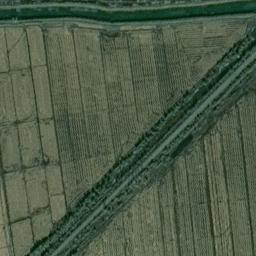

In [ ]:
Image.open(img_path)

In [ ]:
Image.open(mask_path)

In [ ]:
img = cv2.imread(img_path)
mask = cv2.imread(mask_path)

In [ ]:
img.shape

(256, 256, 3)

In [ ]:
mask.shape

(256, 256, 3)

## mask灰度图标注含义

In [ ]:
mask = cv2.imread(image_path) >> 5

# mask 语义分割标注，与原图大小相同
np.unique(mask)

# array = np.unique(mask)

# # 将数组中的每个元素转换为二进制表示
# binary_array = np.array([np.binary_repr(num, width=8) for num in array])

# # 打印结果
# print(binary_array)

array([0, 1, 2, 3, 4, 6], dtype=uint8)

| 类别语义| 灰度图像素值 |
| -----  | ------------ |
| 建筑  | 0            |
| 耕地  | 1            |
| 林地  | 2            |
| 水体  | 3            |
| 道路  | 4            |
| 草地  | 5            |
| 其他  | 6            |

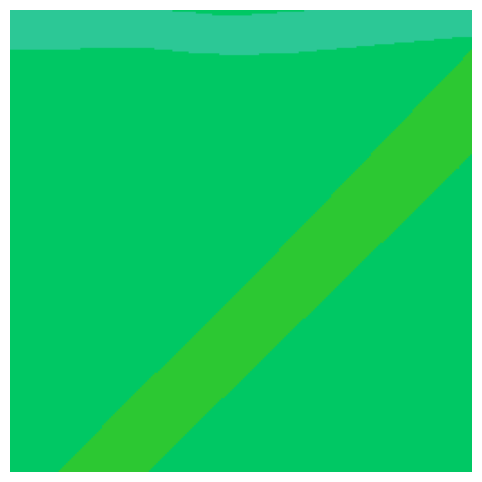

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(mask*50)
plt.axis('off')
plt.show()

## 将语义分割标注叠加在原图上显示

In [ ]:
# 每个类别的 BGR 配色
# palette = [
#     ['background', [127,127,127]],
#     ['red', [0,0,200]],
#     ['green', [0,200,0]],
#     ['white', [144,238,144]],
#     ['seed-black', [30,30,30]],
#     ['seed-white', [8,189,251]]
# ]

palette = [
    ['building', [255, 0, 0]],        # 红色表示建筑
    ['cultivated_land', [0, 255, 0]],  # 绿色表示耕地
    ['forest', [0, 0, 255]],           # 蓝色表示林地
    ['water_body', [0, 128, 255]],     # 水蓝色表示水体
    ['road', [255, 255, 0]],           # 黄色表示道路
    ['grassland', [0, 255, 128]],      # 青绿色表示草地
    ['other', [128, 128, 128]]         # 灰色表示其他
]

In [ ]:
palette_dict = {}
for idx, each in enumerate(palette):
    palette_dict[idx] = each[1]

In [ ]:
palette_dict

{0: [255, 0, 0],
 1: [0, 255, 0],
 2: [0, 0, 255],
 3: [0, 128, 255],
 4: [255, 255, 0],
 5: [0, 255, 128],
 6: [128, 128, 128]}

In [ ]:
mask = mask[:,:,0]

# 将整数ID，映射为对应类别的颜色
viz_mask_bgr = np.zeros((mask.shape[0], mask.shape[1], 3))
for idx in palette_dict.keys():
    viz_mask_bgr[np.where(mask==idx)] = palette_dict[idx]
viz_mask_bgr = viz_mask_bgr.astype('uint8')

# 将语义分割标注图和原图叠加显示
opacity = 0.2 # 透明度越大，可视化效果越接近原图
label_viz = cv2.addWeighted(img, opacity, viz_mask_bgr, 1-opacity, 0)

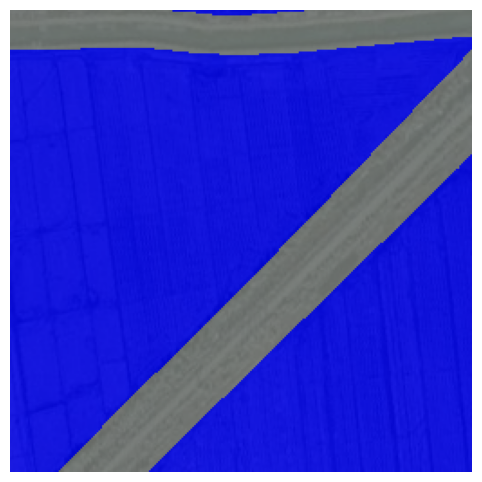

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(label_viz[:,:,::-1])
plt.axis('off')
plt.show()

In [ ]:
cv2.imwrite('outputs/D-1.jpg', label_viz)

True

## 批量可视化图像和标注

In [ ]:
# 指定图像和标注路径

# 训练集
PATH_IMAGE = 'remote_sensing_seg/img_dir/train'
PATH_MASKS = 'remote_sensing_seg/ann_dir/train'

# 测试集
# PATH_IMAGE = 'remote_sensing_seg/img_dir/val'
# PATH_MASKS = 'remote_sensing_seg/ann_dir/val'

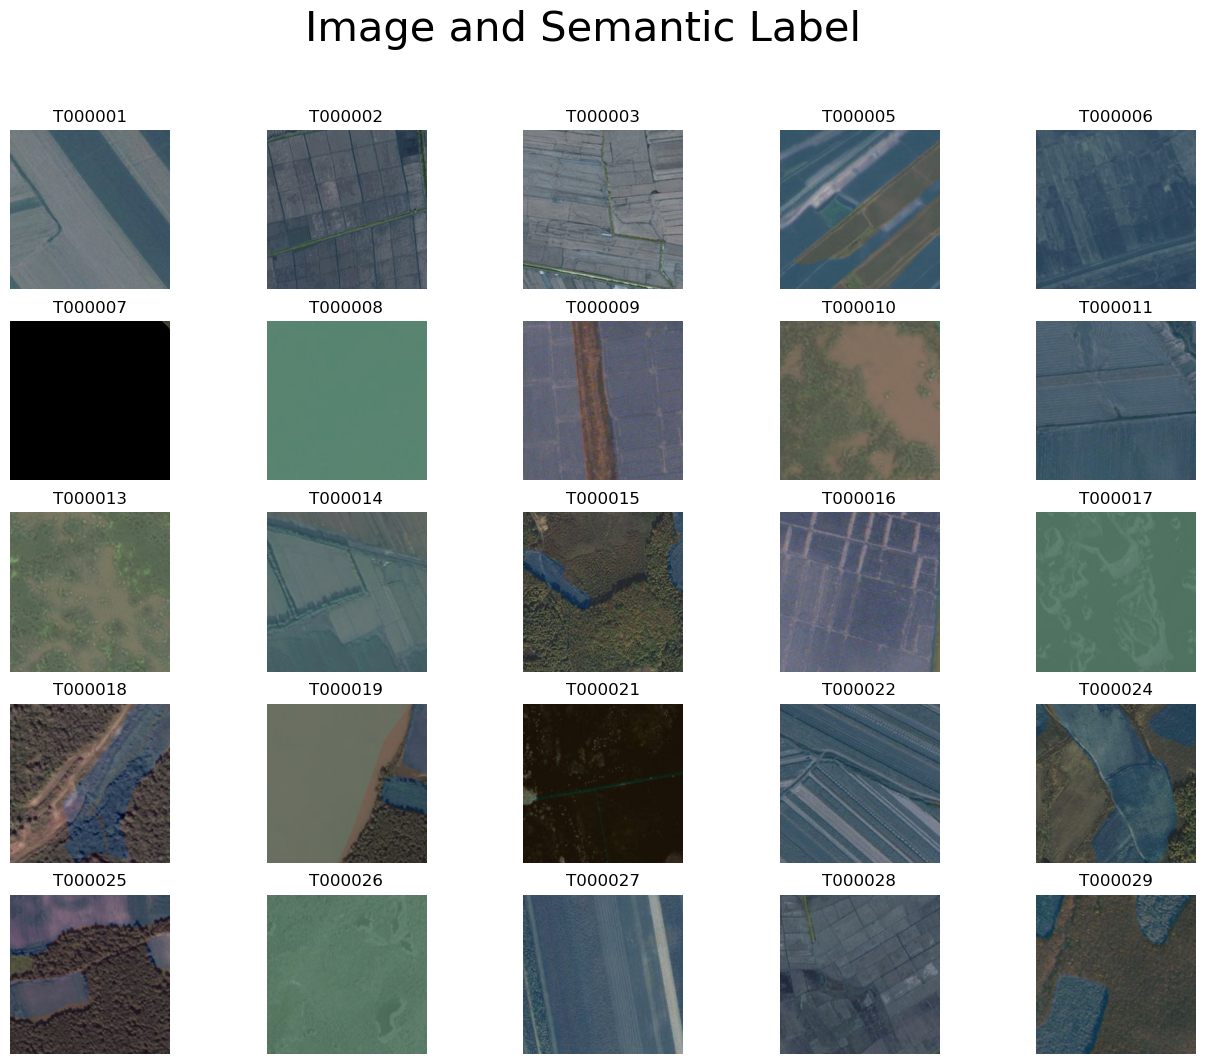

In [ ]:
# n 行 n 列可视化
n = 5

# 透明度越大，可视化效果越接近原图
opacity = 0.9 

fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(16, 12))

for i, file_name in enumerate(os.listdir(PATH_IMAGE)[:n**2]):
    
    # 载入图像和标注
    img_path = os.path.join(PATH_IMAGE, file_name)
    mask_path = os.path.join(PATH_MASKS, file_name.split('.')[0]+'.png')
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)>>5
    mask = mask[:,:,0]

    # 将预测的整数ID，映射为对应类别的颜色
    viz_mask_bgr = np.zeros((mask.shape[0], mask.shape[1], 3))
    for idx in palette_dict.keys():
        viz_mask_bgr[np.where(mask==idx)] = palette_dict[idx]
    viz_mask_bgr = viz_mask_bgr.astype('uint8')

    # 将语义分割标注图和原图叠加显示
    label_viz = cv2.addWeighted(img, opacity, viz_mask_bgr, 1-opacity, 0)
    
    # 可视化
    axes[i//n, i%n].imshow(label_viz[:,:,::-1])
    axes[i//n, i%n].axis('off') # 关闭坐标轴显示
    axes[i//n, i%n].set_title(file_name.split('.')[0], fontsize=12)
fig.suptitle('Image and Semantic Label', fontsize=30)
# plt.tight_layout()
plt.savefig('outputs/D-2.jpg')
plt.show()

## 载入训练日志

In [10]:
# 日志文件路径
log_path = './work_dirs/Dataset-PSPNet/20240104_024207/vis_data/scalars.json'

In [11]:
with open(log_path, "r") as f:
    json_list = f.readlines()

In [12]:
len(json_list)

181

In [13]:
eval(json_list[4])

{'lr': 0.009665347338051444,
 'data_time': 0.27870099544525145,
 'loss': 0.8217880964279175,
 'decode.loss_ce': 0.5725979924201965,
 'decode.acc_seg': 82.78433227539062,
 'aux.loss_ce': 0.2491901010274887,
 'aux.acc_seg': 81.53120422363281,
 'time': 0.984354043006897,
 'iter': 3000,
 'memory': 20141,
 'step': 3000}

In [14]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
for each in json_list[:-1]:
    if 'aAcc' in each:
        df_test = df_test._append(eval(each), ignore_index=True)
    else:
        df_train = df_train._append(eval(each), ignore_index=True)

In [15]:
df_train

,lr,data_time,loss,decode.loss_ce,decode.acc_seg,aux.loss_ce,aux.acc_seg,time,iter,memory,step
0,0.009949,0.311366,0.955729,0.662777,78.667603,0.292952,76.027199,1.015682,457.0,20141.0,457.0
1,0.009889,0.287259,0.860610,0.592000,83.001221,0.268610,80.982971,0.990634,1000.0,20141.0,1000.0
2,0.009777,0.285878,0.809991,0.557899,82.297600,0.252092,79.536301,0.990335,2000.0,20141.0,2000.0
3,0.009665,0.278701,0.821788,0.572598,82.784332,0.249190,81.531204,0.984354,3000.0,20141.0,3000.0
4,0.009553,0.308242,0.752057,0.522393,82.932938,0.229663,81.023613,1.012043,4000.0,20141.0,4000.0
...,...,...,...,...,...,...,...,...,...,...,...
116,0.000100,0.278513,0.474655,0.308077,86.759605,0.166578,84.042473,0.998925,116000.0,20141.0,116000.0
117,0.000100,0.291841,0.449109,0.289480,89.422272,0.159629,86.750999,1.000270,117000.0,20141.0,117000.0
118,0.000100,0.290025,0.448533,0.288086,90.635956,0.160447,87.938576,0.999755,118000.0,20141.0,118000.0
119,0.000100,0.295349,0.465046,0.303163,88.985748,0.161882,86.320892,0.996533,119000.0,20141.0,119000.0


In [16]:
df_test

,aAcc,mIoU,mAcc,data_time,time,step
0,85.06,47.24,51.64,0.001893,0.042281,2000.0
1,85.77,51.25,56.90,0.001923,0.043420,4000.0
2,84.05,51.47,59.43,0.001851,0.042269,6000.0
3,86.68,53.23,58.98,0.001941,0.042513,8000.0
4,81.76,46.61,53.06,0.001915,0.042531,10000.0
5,87.35,54.67,59.89,0.001885,0.042404,12000.0
6,87.70,54.59,60.03,0.001837,0.042510,14000.0
7,88.39,55.85,60.99,0.001823,0.042448,16000.0
8,87.94,55.46,61.57,0.001949,0.043822,18000.0
9,80.51,47.30,56.03,0.001838,0.042535,20000.0


## 导出训练日志表格

In [17]:
df_train.to_csv('图表/训练日志-训练集.csv', index=False)
df_test.to_csv('图表/训练日志-测试集.csv', index=False)

## 可视化辅助函数

In [18]:
from matplotlib import colors as mcolors
import random
random.seed(124)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'sienna', 'chocolate', 'yellow', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'darkslategray', 'darkslategrey', 'teal', 'darkcyan', 'dodgerblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink']
markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
linestyle = ['--', '-.', '-']

def get_line_arg():
    '''
    随机产生一种绘图线型
    '''
    line_arg = {}
    line_arg['color'] = random.choice(colors)
    # line_arg['marker'] = random.choice(markers)
    line_arg['linestyle'] = random.choice(linestyle)
    line_arg['linewidth'] = random.randint(1, 4)
    # line_arg['markersize'] = random.randint(3, 5)
    return line_arg

## 训练集损失函数

In [19]:
metrics = ['loss', 'decode.loss_ce', 'aux.loss_ce']

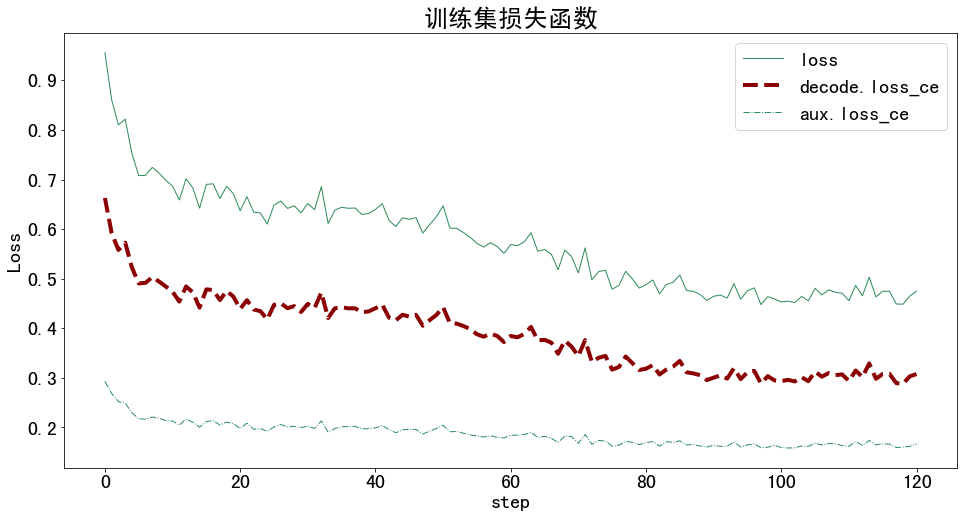

In [20]:
plt.figure(figsize=(16, 8))

x = df_train['step']
for y in metrics:
    try:
        plt.plot(df_train[y], label=y, **get_line_arg())
    except:
        pass

plt.tick_params(labelsize=20)
plt.xlabel('step', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('训练集损失函数', fontsize=25)

plt.legend(fontsize=20)

plt.savefig('图表/训练集损失函数.pdf', dpi=120, bbox_inches='tight')

plt.show()

## 训练集准确率

In [21]:
metrics = ['decode.acc_seg', 'aux.acc_seg']

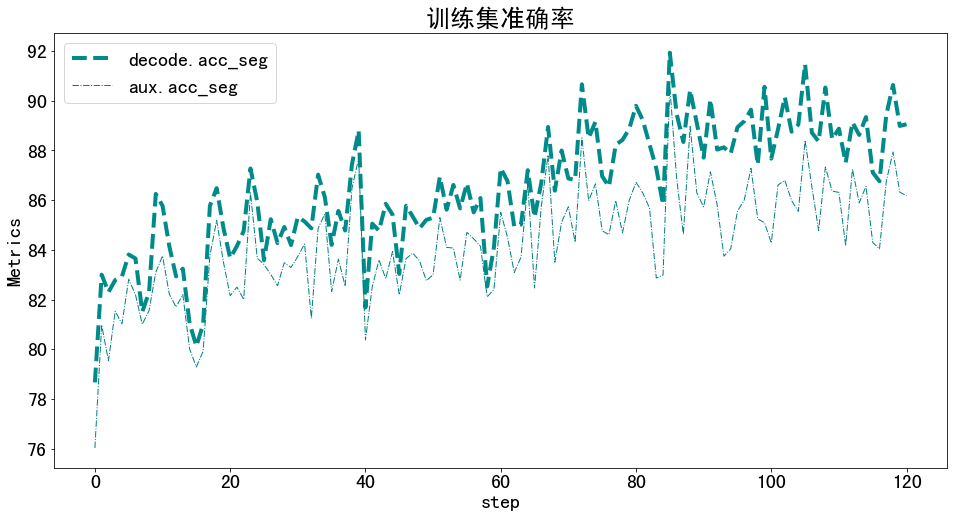

In [22]:
plt.figure(figsize=(16, 8))

x = df_train['step']
for y in metrics:
    try:
        plt.plot(df_train[y], label=y, **get_line_arg())
    except:
        pass

plt.tick_params(labelsize=20)
plt.xlabel('step', fontsize=20)
plt.ylabel('Metrics', fontsize=20)
plt.title('训练集准确率', fontsize=25)

plt.legend(fontsize=20)

plt.savefig('图表/训练集准确率.pdf', dpi=120, bbox_inches='tight')

plt.show()

## 测试集评估指标

In [23]:
df_test.columns

Index(['aAcc', 'mIoU', 'mAcc', 'data_time', 'time', 'step'], dtype='object')

In [24]:
metrics = ['aAcc', 'mIoU', 'mAcc', 'mDice', 'mFscore', 'mPrecision', 'mRecall']

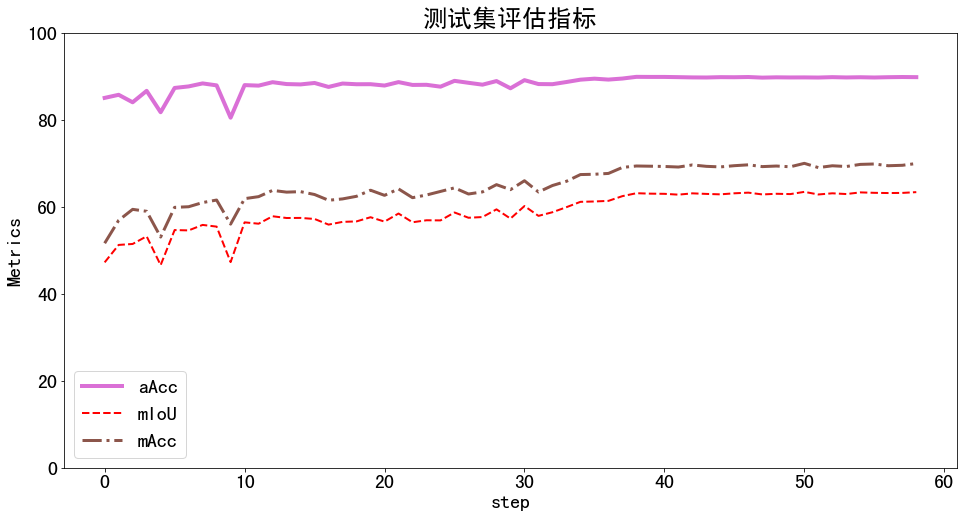

In [25]:
plt.figure(figsize=(16, 8))

x = df_test['step']
for y in metrics:
    try:
        plt.plot(df_test[y], label=y, **get_line_arg())
    except:
        pass

plt.tick_params(labelsize=20)
plt.ylim([0, 100])
plt.xlabel('step', fontsize=20)
plt.ylabel('Metrics', fontsize=20)
plt.title('测试集评估指标', fontsize=25)

plt.legend(fontsize=20)

plt.savefig('图表/测试集分类评估指标.pdf', dpi=120, bbox_inches='tight')

plt.show()